In [3]:
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

In [3]:
adata = sc.read_h5ad('datasets/multiome/multiome_rna.h5ad')
adata

AnnData object with n_obs × n_vars = 2535 × 2000
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [13]:
from simvi.model import SimVI
SimVI.setup_anndata(adata)
edge_index = SimVI.extract_edge_index(adata,n_neighbors=10)

from pytorch_lightning.utilities.seed import seed_everything
seed_everything(0)
model = SimVI(adata,kl_weight=1,kl_gatweight=0.01,lam_mi=1000,permutation_rate=0.5,n_spatial=20,n_intrinsic=20)
train_loss, val_loss = model.train(edge_index,max_epochs=200,batch_size=500,use_gpu=True,mae_epochs=50,device='cuda:2')
adata.obsm['simvi_z'] = model.get_latent_representation(edge_index,representation_kind='intrinsic',give_mean=True)
adata.obsm['simvi_s'] = model.get_latent_representation(edge_index,representation_kind='interaction',give_mean=True)
adata.obsm['simvi'] = np.hstack((adata.obsm['simvi_z'],adata.obsm['simvi_s']))

Global seed set to 0
Epoch 200/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.11it/s, train_loss=637, val_loss=638.0327]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


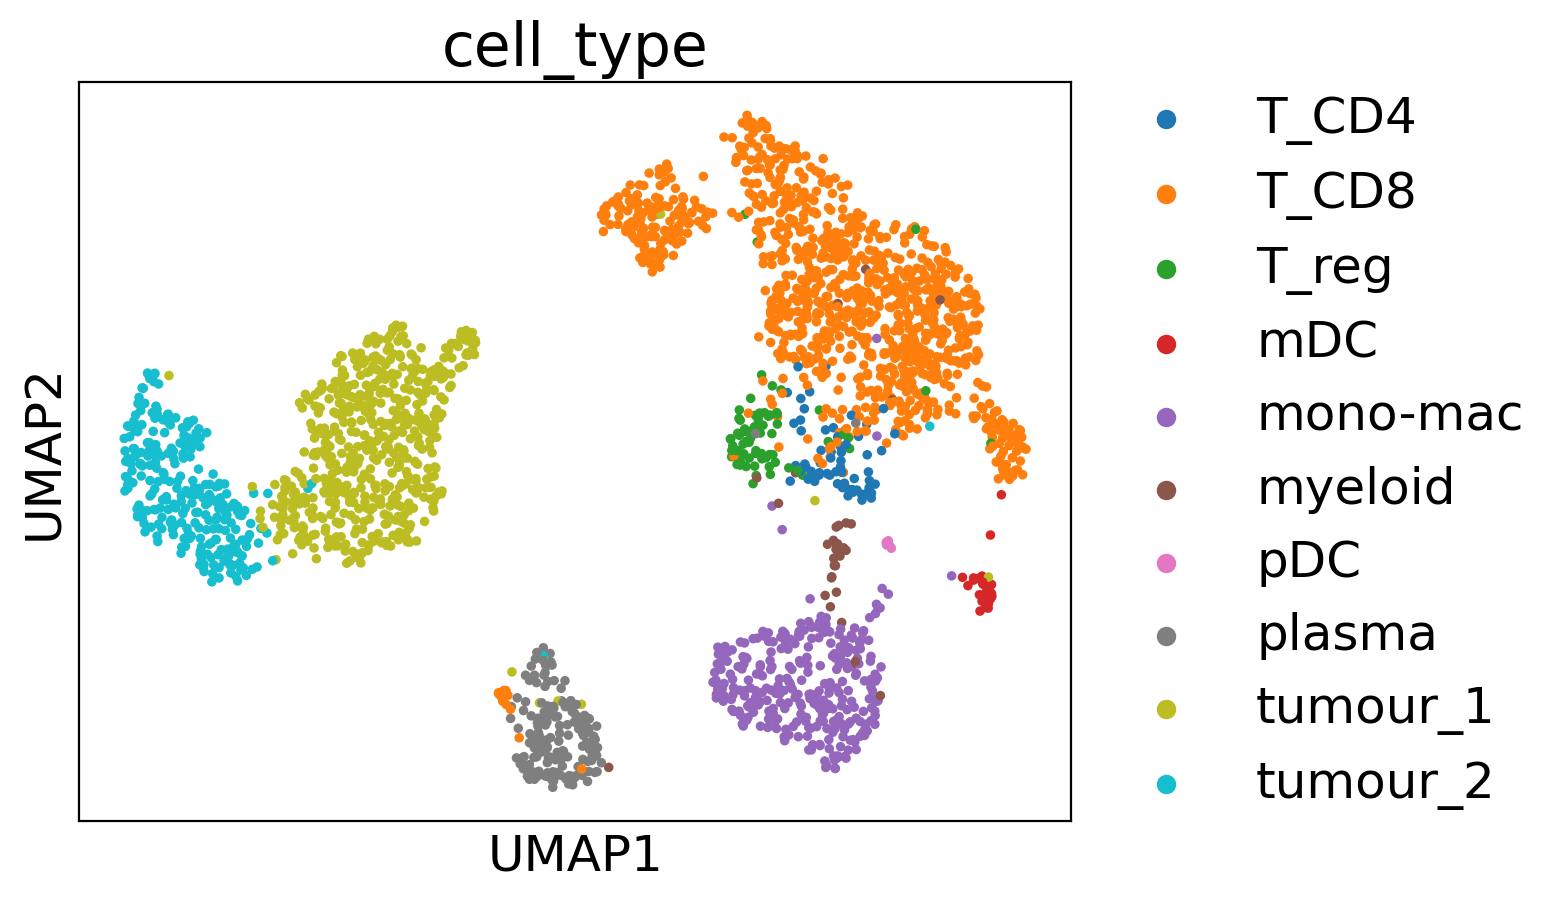

In [472]:
sc.pp.neighbors(adata,use_rep='simvi_z')
sc.tl.umap(adata)
sc.pl.umap(adata,color=['cell_type'])

In [222]:
def annotate(adata,label,names):
    new_cluster_names = np.array(names)
    celltype_label = new_cluster_names[np.array(list(map(int, adata.obs['leiden'].tolist())))]
    adata.obs[label] = celltype_label
sc.tl.leiden(adata,resolution=1)    
annotate(adata,'SIMVI niche',['Tumor 1','Infiltrating Mp (Tumor 2)','Infiltrating CD8 T (Intermediate)',
                        'Uninfiltrated immune','Infiltrating CD8 T (Tumor 2)','Tumor 2','Infiltrating CD8 T (Intermediate)',
                        'Infiltrating CD8 T (Tumor 1)', 'Infiltrating Mp (Tumor 1)','Infiltrating Mp (Tumor 1)','Tumor 1 (Hypoxia)',
                        'Infiltrating CD8 T (Intermediate)','Infiltrating CD8 T (Tumor 2)','Tumor 1'])
adata

AnnData object with n_obs × n_vars = 2535 × 2000
    obs: 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden', 'S', 'niche', 'SIMVI niche'
    var: 'gene_ids', 'feature_types'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'leiden', 'leiden_colors', 'niche_colors', 'SIMVI niche_colors'
    obsm: 'spatial', 'simvi_z', 'simvi_lz', 'simvi_s', 'simvi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [226]:
adata.uns['SIMVI niche_colors'] = ['#80FF08','#D7EF9B', '#1b7837', '#CC66FF','#ae017e','#FF9900','#F52831','#0099FF', '#bdbdbd']

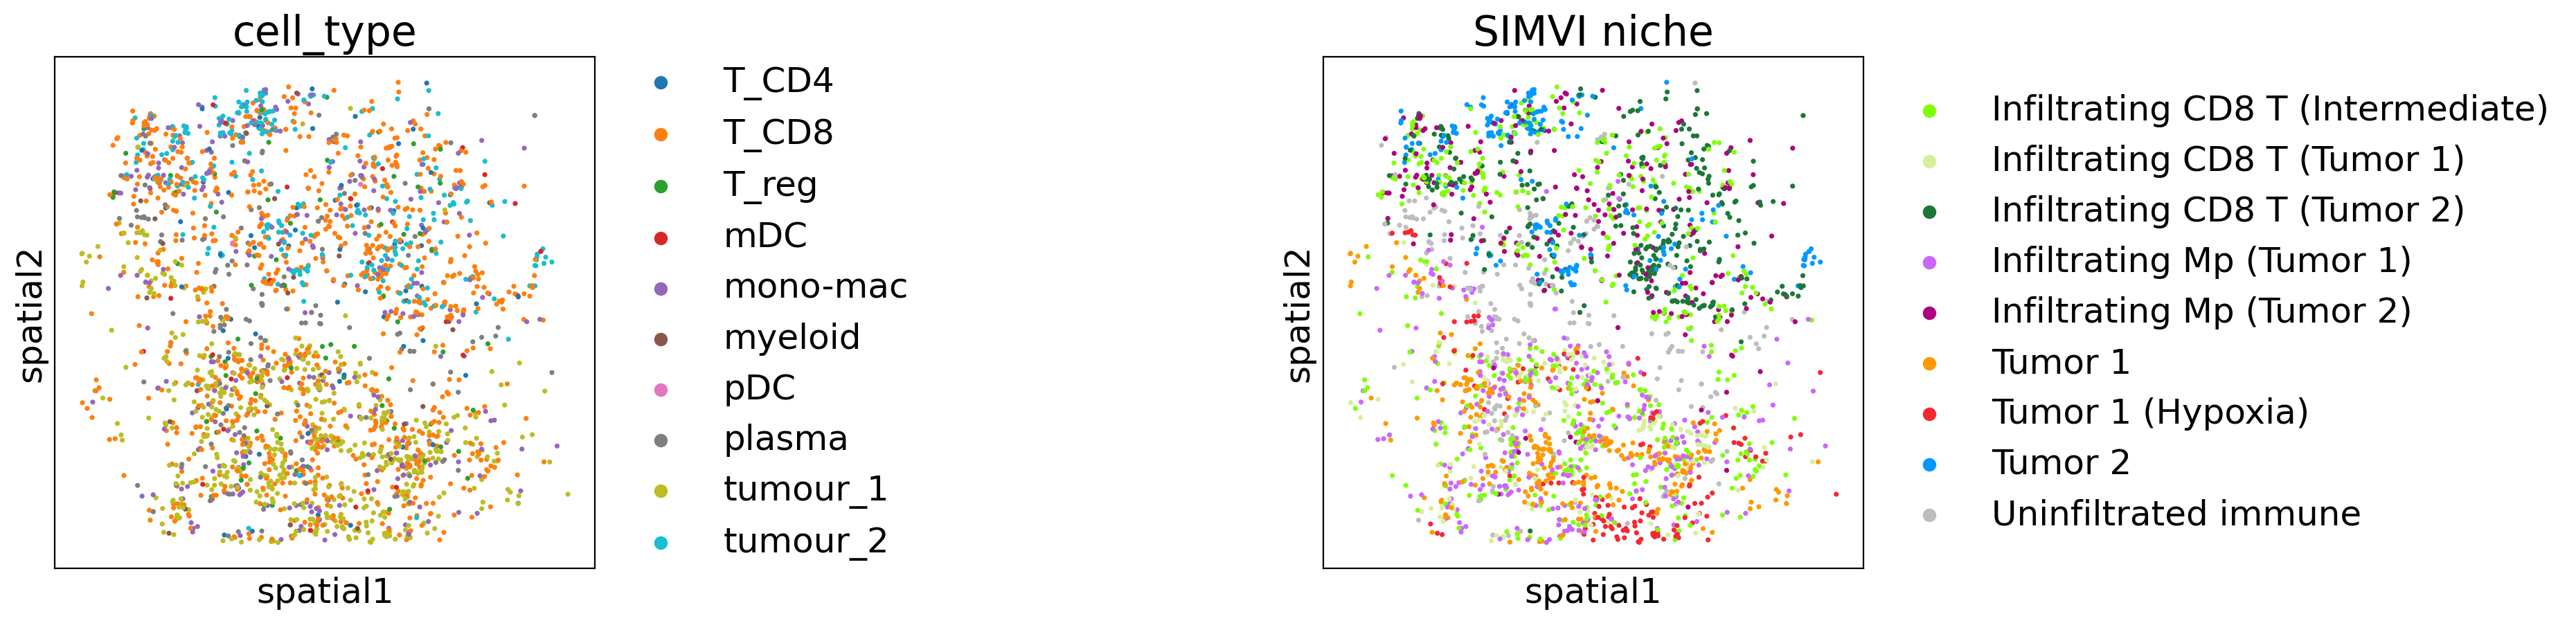

In [227]:
sc.pl.spatial(adata,color=['cell_type','SIMVI niche'],wspace=0.5,spot_size=55,save='multiome_simvi.pdf') 

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


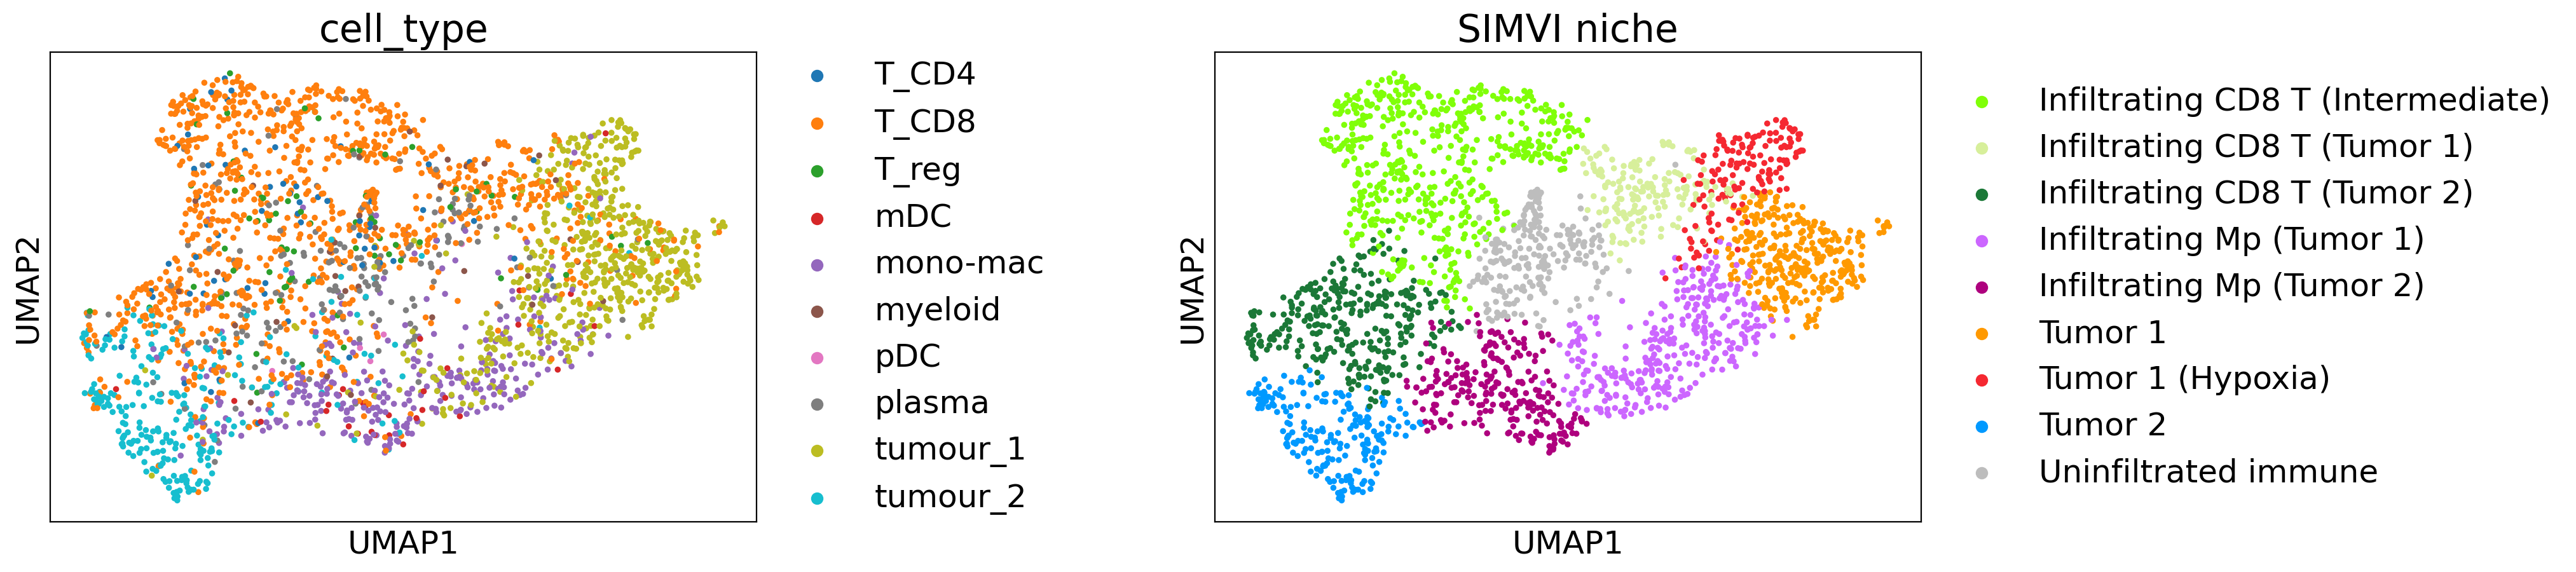

In [228]:
sc.pl.umap(adata,color=['cell_type','SIMVI niche'],wspace=0.5,vmax='p99.5',save='multiome_simvi.pdf')

In [39]:
adata_rna = adata.raw.to_adata()
adata_rna

AnnData object with n_obs × n_vars = 2535 × 36601
    obs: 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'simvi_z', 'simvi_lz', 'simvi_s', 'simvi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [264]:
adata_rna.obs['SIMVI niche'] = adata.obs['SIMVI niche'].values.copy()
adata_tumor2 = adata_rna[adata_rna.obs['cell_type']=='tumour_2'].copy()
adata_tumor2 = adata_tumor2[adata_tumor2.obs['SIMVI niche'].isin(['Infiltrating CD8 T (Tumor 2)','Tumor 2','Infiltrating Mp (Tumor 2)'])]

In [40]:
sc.pp.filter_genes(adata_rna,min_counts=50)
adata_rna

AnnData object with n_obs × n_vars = 2535 × 12464
    obs: 'cell_type', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'cell_type_colors', 'leiden'
    obsm: 'spatial', 'simvi_z', 'simvi_lz', 'simvi_s', 'simvi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [97]:
se_list, r2_zlist, r2_slist, r2_zpvlist, r2_spvlist, S = model.get_se(edge_index,adata=adata_rna,num_arch =8, Kfold=1,eps=1e-10,cell_type_label='cell_type',positivity_filter=False,transformation='none')

In [98]:
se = np.sum(se_list,axis=0)
adata_se = adata_rna.copy()
adata_se.X = se

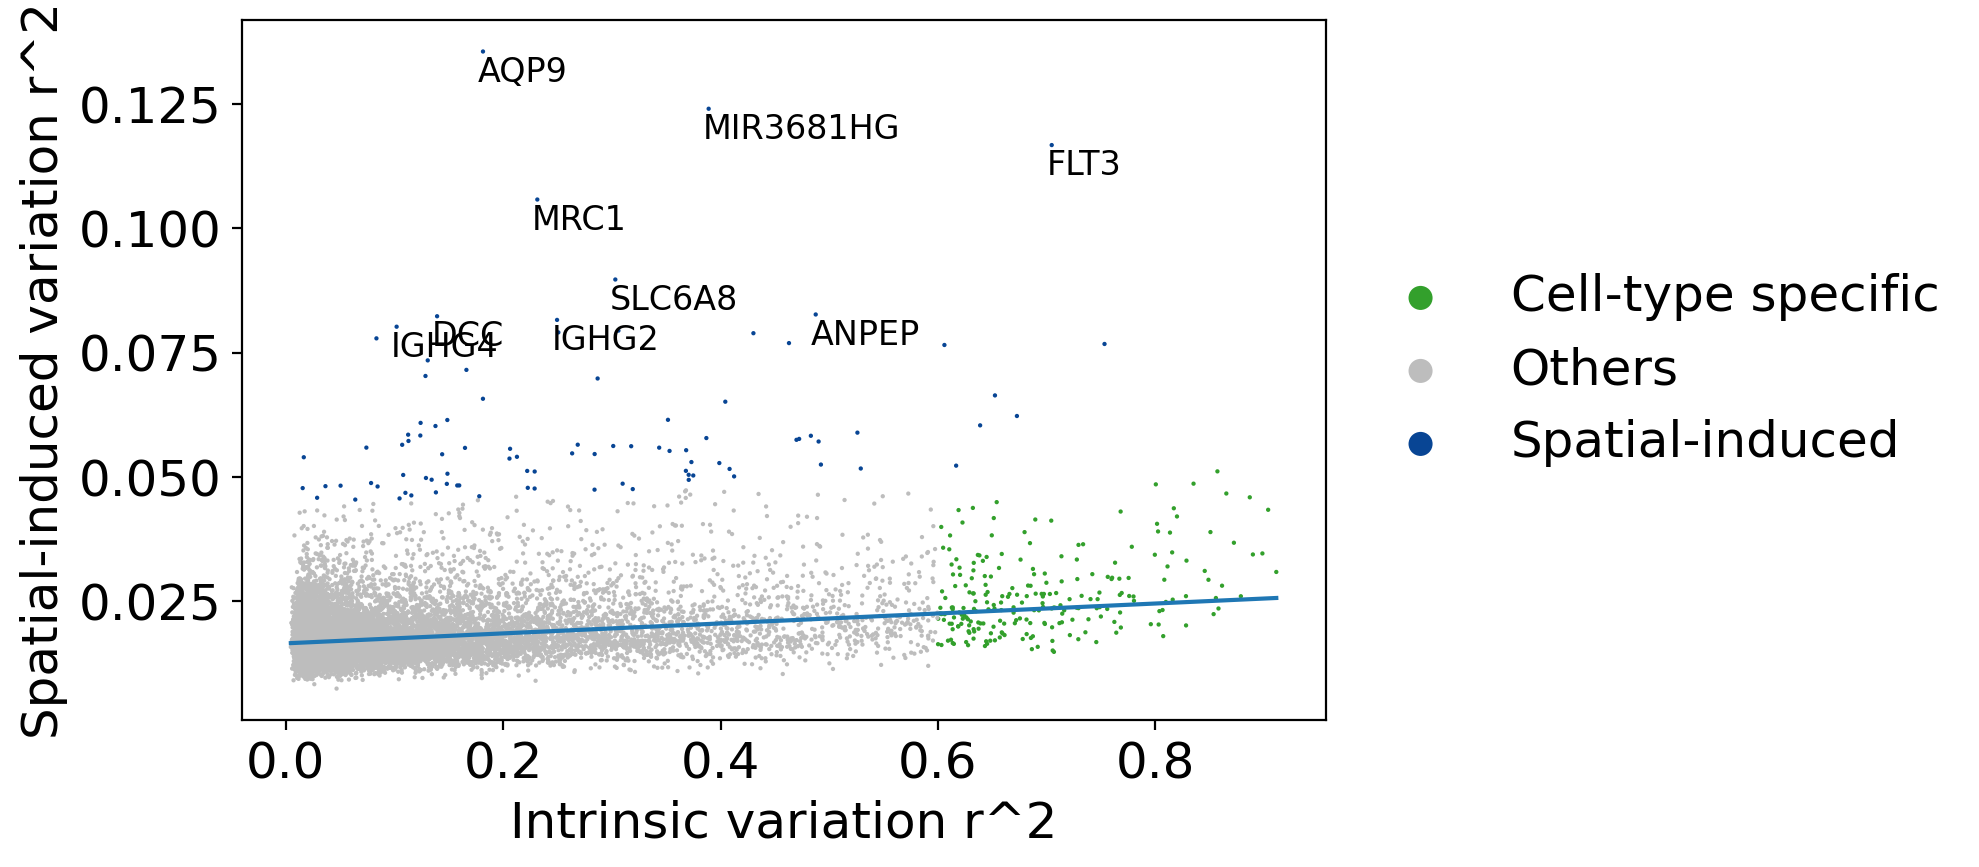

In [293]:
#adata_rna.var['r2_z'] = np.max(r2_zlist,axis=0)
#adata_rna.var['r2_s'] = np.max(r2_slist,axis=0)

from sklearn.linear_model import HuberRegressor

hr = HuberRegressor()
hr.fit(adata_rna.var['r2_z'].values.reshape(-1,1),adata_rna.var['r2_s'].values)


adata_rna.var['class'] = 'Others'

adata_rna.var['class'][adata_rna.var['r2_z']>0.6] = 'Cell-type specific'
adata_rna.var['class'][np.abs(adata_rna.var['r2_s'].values - hr.predict(adata_rna.var['r2_z'].values.reshape(-1,1)) ) / hr.scale_ > 10] = 'Spatial-induced'

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.size"] = 18

adata_rna.uns['class_colors'] = ['#33a02c','#bdbdbd','#084594']





sc.pl.scatter(adata_rna.copy(),x='r2_z',y='r2_s',show=False,color='class')
plt.plot(adata_rna.var['r2_z'].values[np.argsort(adata_rna.var['r2_z'].values)],hr.predict(adata_rna.var['r2_z'].values.reshape(-1,1))[np.argsort(adata_rna.var['r2_z'].values)])

for i in range(adata_rna.var['r2_s'].shape[0]):
    if adata_rna.var['r2_s'][i] > 0.08 or adata_rna.var['r2_z'][i] > 0.95:
        plt.text(adata_rna.var['r2_z'][i]-0.005,adata_rna.var['r2_s'][i]-0.006,adata_rna.var_names[i],fontsize=12)
        
plt.xlabel('Intrinsic variation r^2')
plt.ylabel('Spatial-induced variation r^2')
plt.title('')

plt.savefig('figures/r2scatter_multiome_rna.pdf')

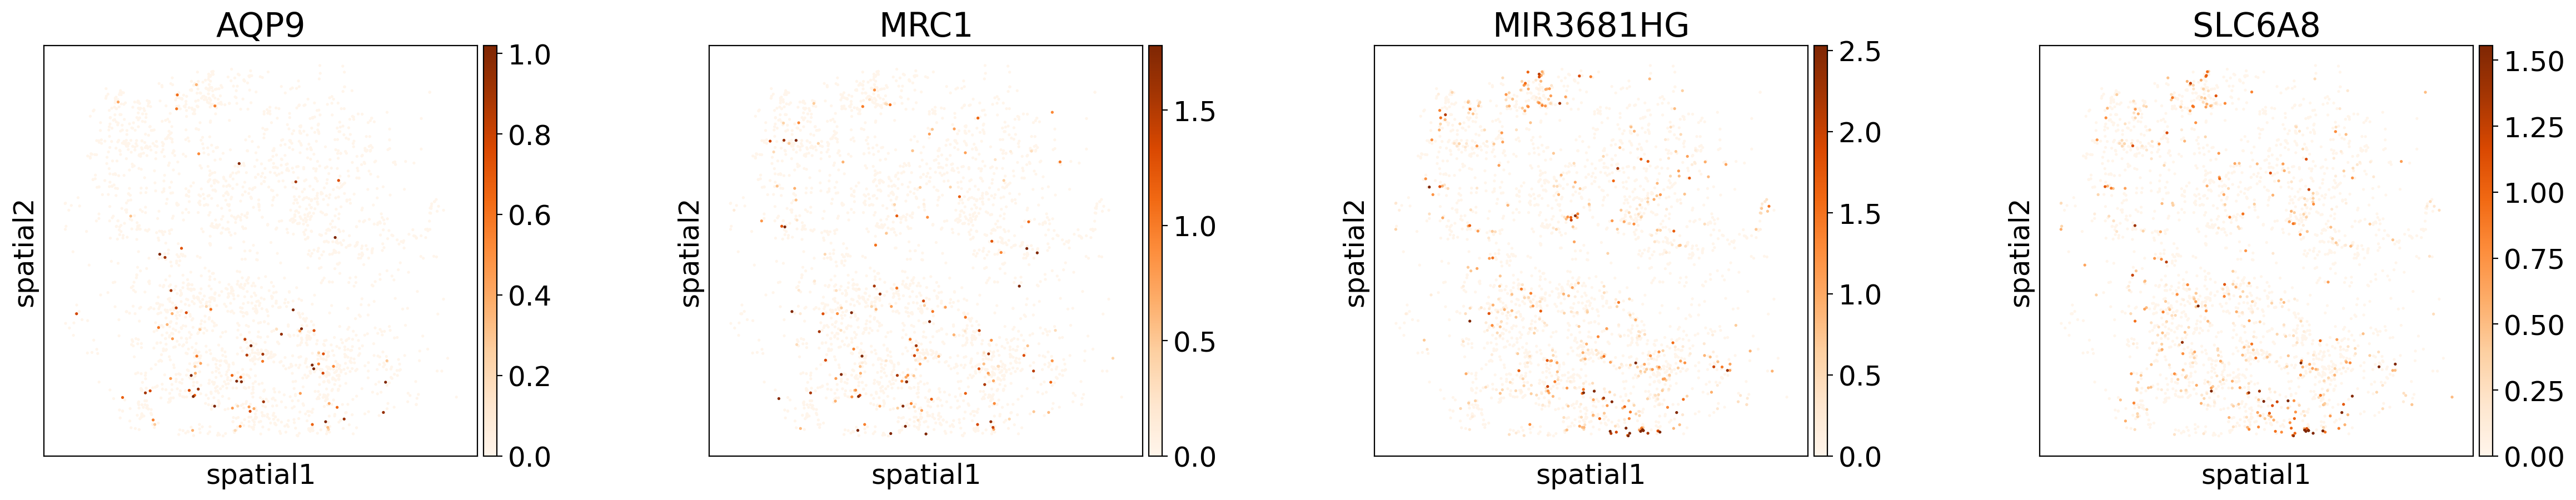

In [477]:
sc.pl.spatial(adata,color=['AQP9','MRC1','MIR3681HG','SLC6A8'],spot_size=40,cmap='Oranges',vmax='p99.5',vmin=0,ncols=6)

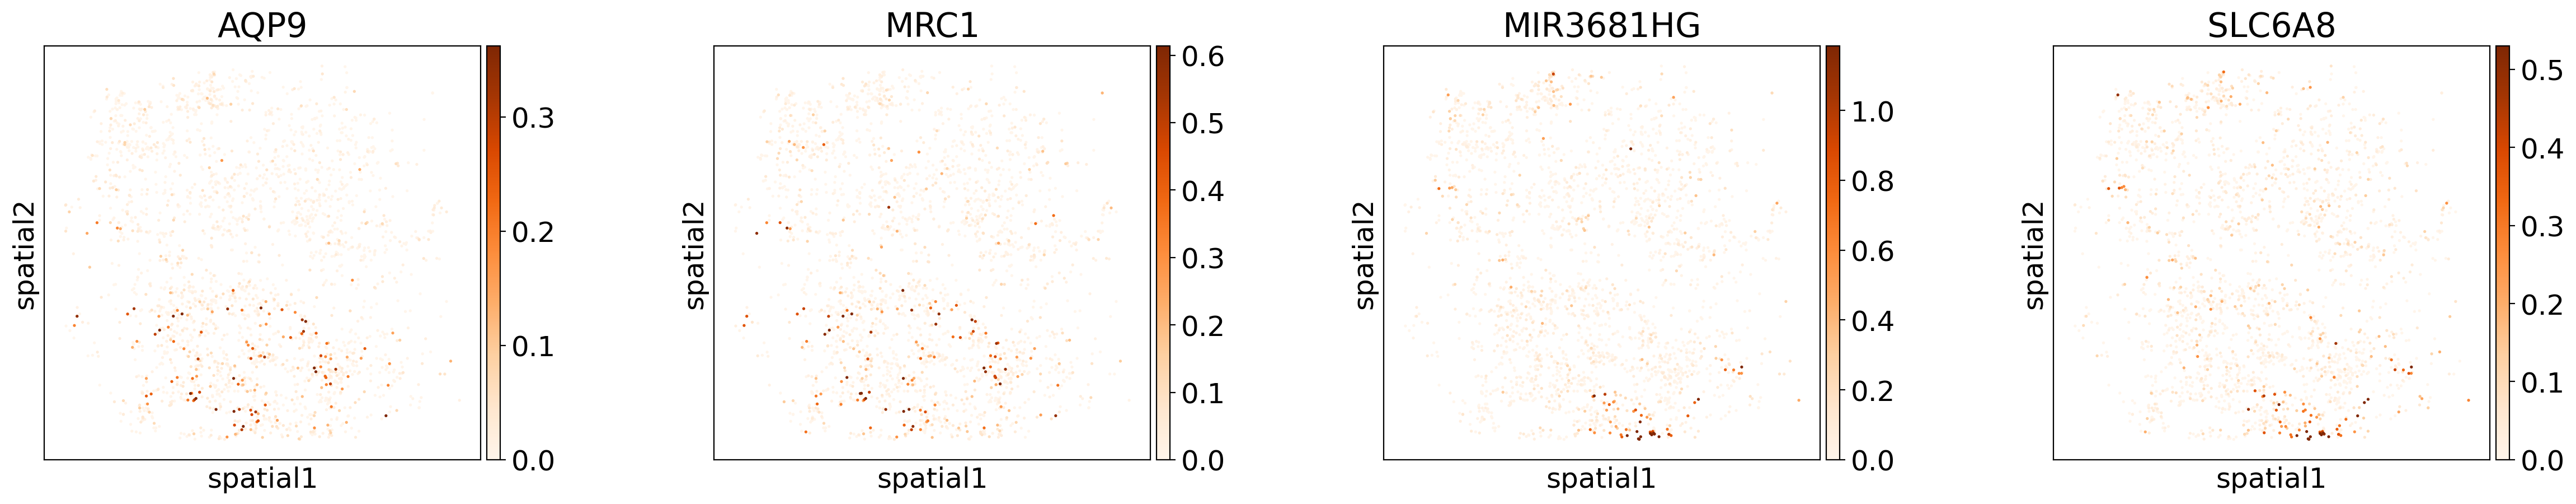

In [479]:
sc.pl.spatial(adata_se,color=['AQP9','MRC1','MIR3681HG','SLC6A8'],spot_size=40,cmap='Oranges',vmax='p99.5',vmin=0,ncols=6)

In [4]:
adata_atac = sc.read_h5ad('datasets/multiome/multiome_atac_full.h5ad')
adata_atac

AnnData object with n_obs × n_vars = 2535 × 53451
    obs: 'cell_type'
    obsm: 'spatial'

In [5]:
sc.pp.pca(adata_atac,zero_center=False)
adata_atac = sc.AnnData(adata_atac.obsm['X_pca'][:,1:],obs=adata_atac.obs.copy())

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


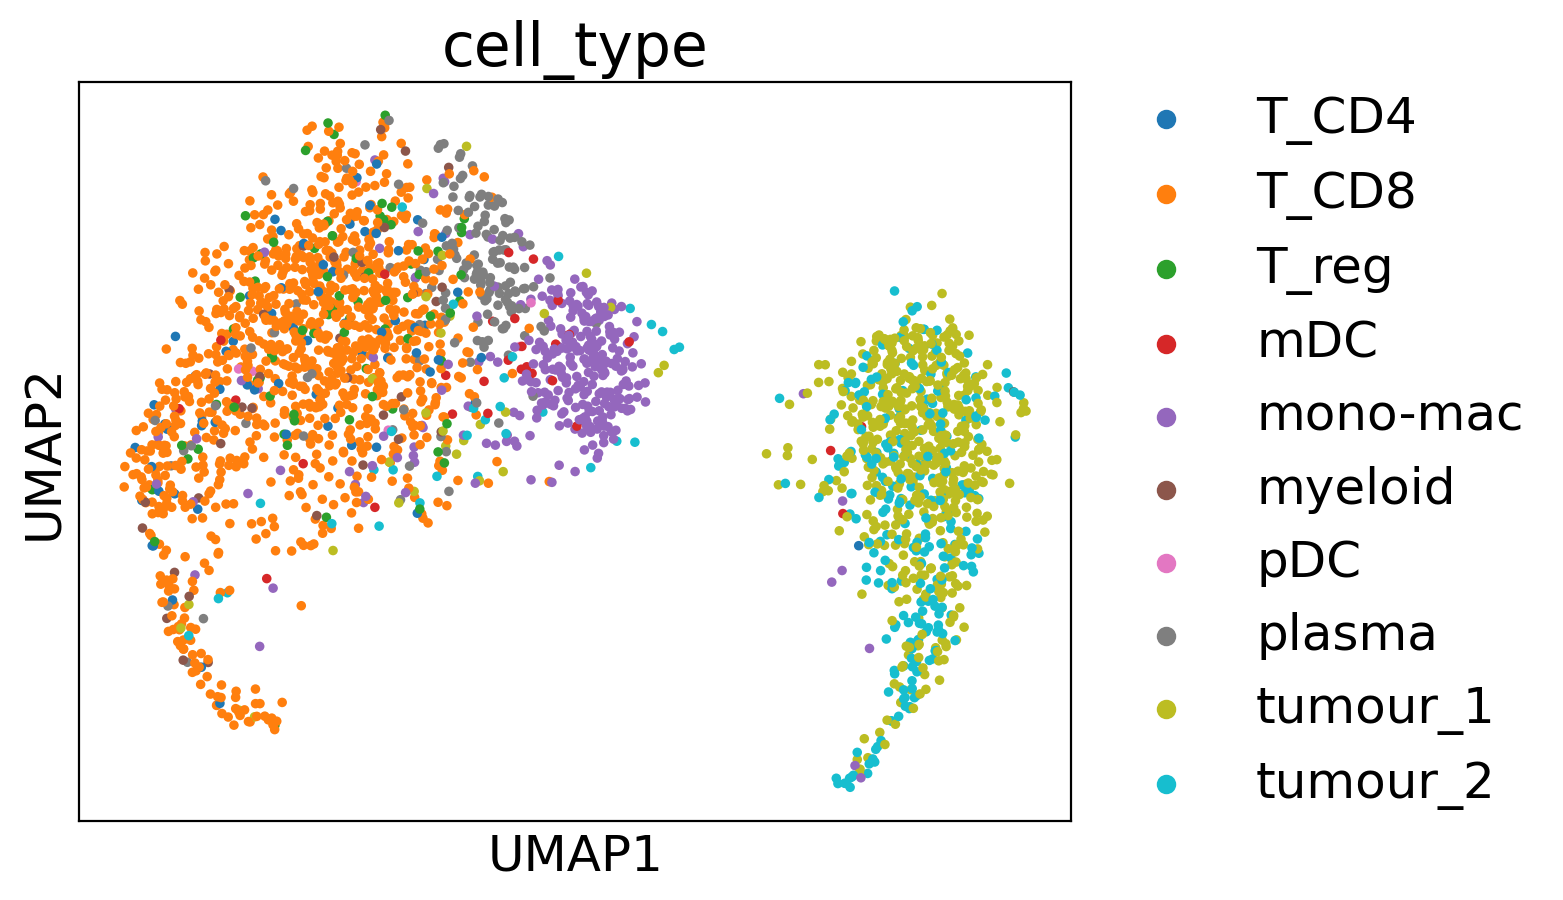

In [8]:
sc.pp.neighbors(adata_atac)
sc.tl.umap(adata_atac)


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.size"] = 18
sc.pl.umap(adata_atac,color=['cell_type'],wspace=0.5,save='multiome_atac_lsiremovefirst.pdf')

In [326]:
#sc.pp.highly_variable_genes(adata_atac,n_top_genes=5000)
adata_atac = adata_atac[:,adata_atac.var['highly_variable']]

In [396]:
adata_atac.obsm['simvi_z'] = adata.obsm['simvi_z'].copy()
adata_atac.obsm['simvi_s'] = adata.obsm['simvi_s'].copy()
se_list, r2_zlist, r2_slist, r2_zpvlist, r2_spvlist, S = model.get_se(edge_index,adata=adata_atac,num_arch =8, Kfold=1,eps=1e-10,cell_type_label='cell_type',positivity_filter=False,transformation='none')

In [ ]:
adata_atac_se = adata_atac.copy()
adata_atac_se.X = np.sum(se_list,axis=0)
sc.pp.neighbors(adata_atac_se)
sc.tl.umap(adata_atac_se)
sc.tl.leiden(adata_atac_se,resolution=0.5)

adata_atac_se.obs['SIMVI niche'] = adata[adata_atac_se.obs_names].obs['SIMVI niche'].values.copy()
sc.pl.umap(adata_atac_se,color=['cell_type','leiden','SIMVI niche'],wspace=0.5,save='multiome_atac_se.pdf')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


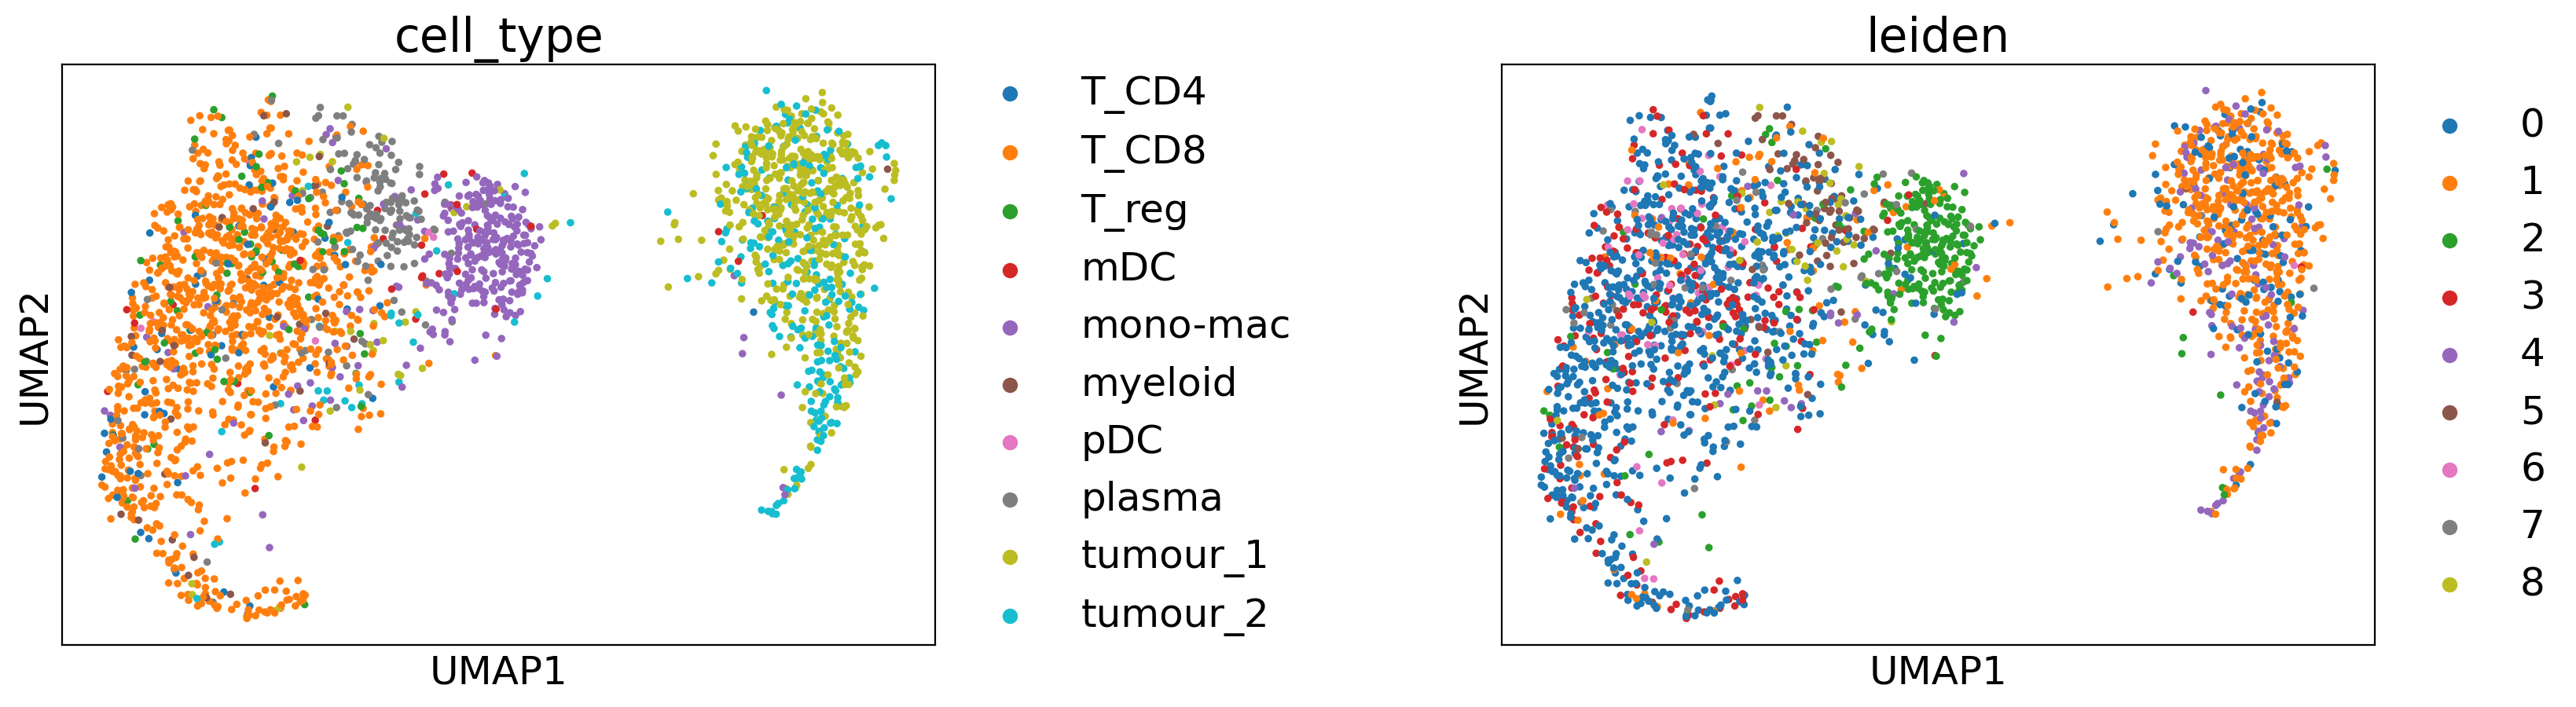

In [411]:
#sc.pp.pca(adata_atac,zero_center=False)
sc.pp.neighbors(adata_atac)
sc.tl.umap(adata_atac)
sc.pl.umap(adata_atac,color=['cell_type','leiden'],wspace=0.5,save='multiome_atac_lsi.pdf')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


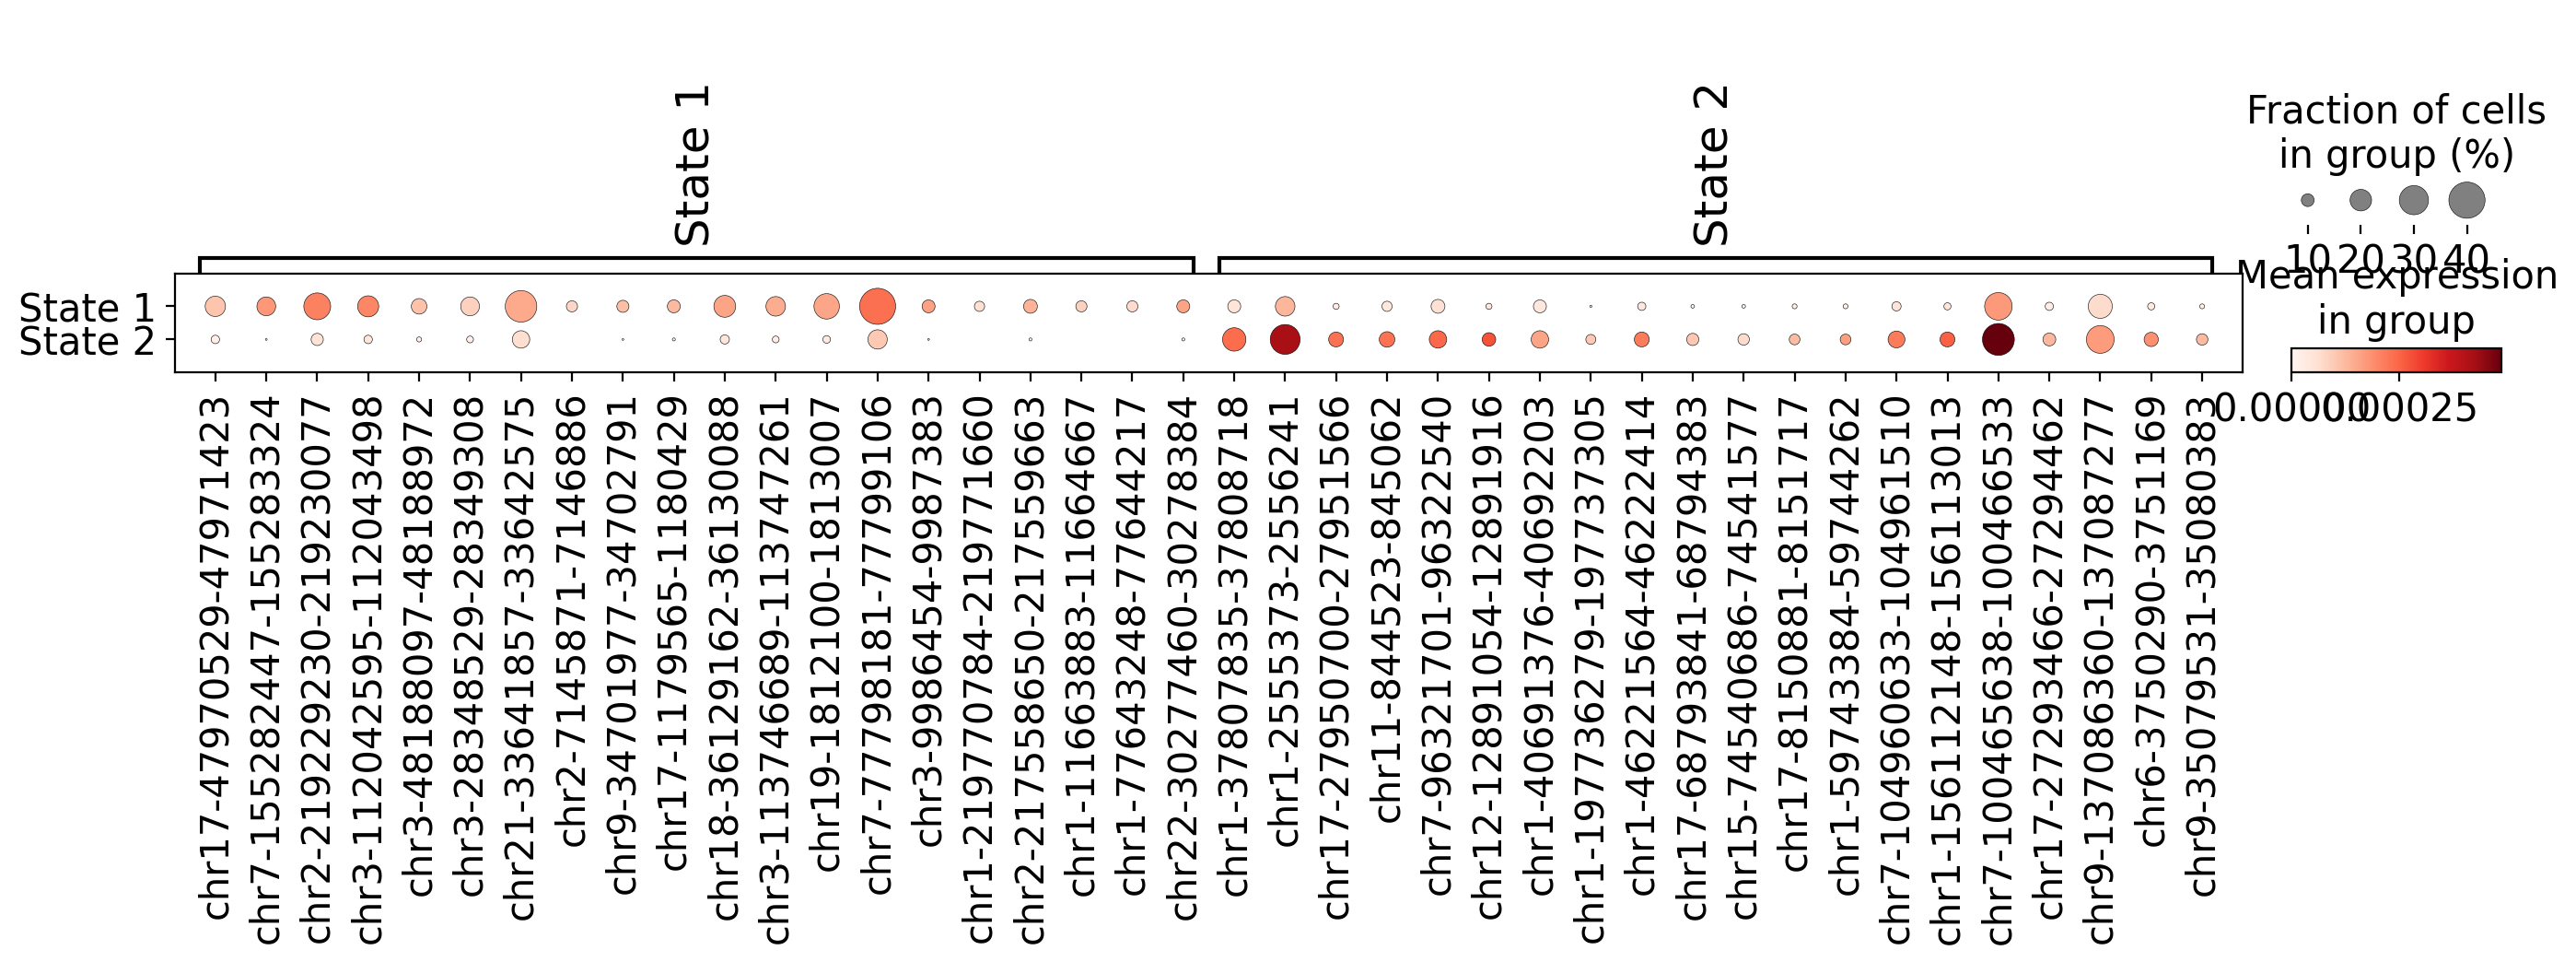

In [480]:
adata_atac = sc.read_h5ad('datasets/multiome/multiome_atac_full.h5ad')
adata_atac.obs['leiden'] = adata_atac_se.obs['leiden'].values.copy()
adata_atac_tumor2 = adata_atac[adata_atac.obs['cell_type']=='tumour_2'].copy()
adata_atac_tumor2 = adata_atac_tumor2[adata_atac_tumor2.obs['leiden'].isin(['4','1'])]
sc.tl.rank_genes_groups(adata_atac_tumor2,'state')
sc.pl.rank_genes_groups_dotplot(adata_atac_tumor2,n_genes=20)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


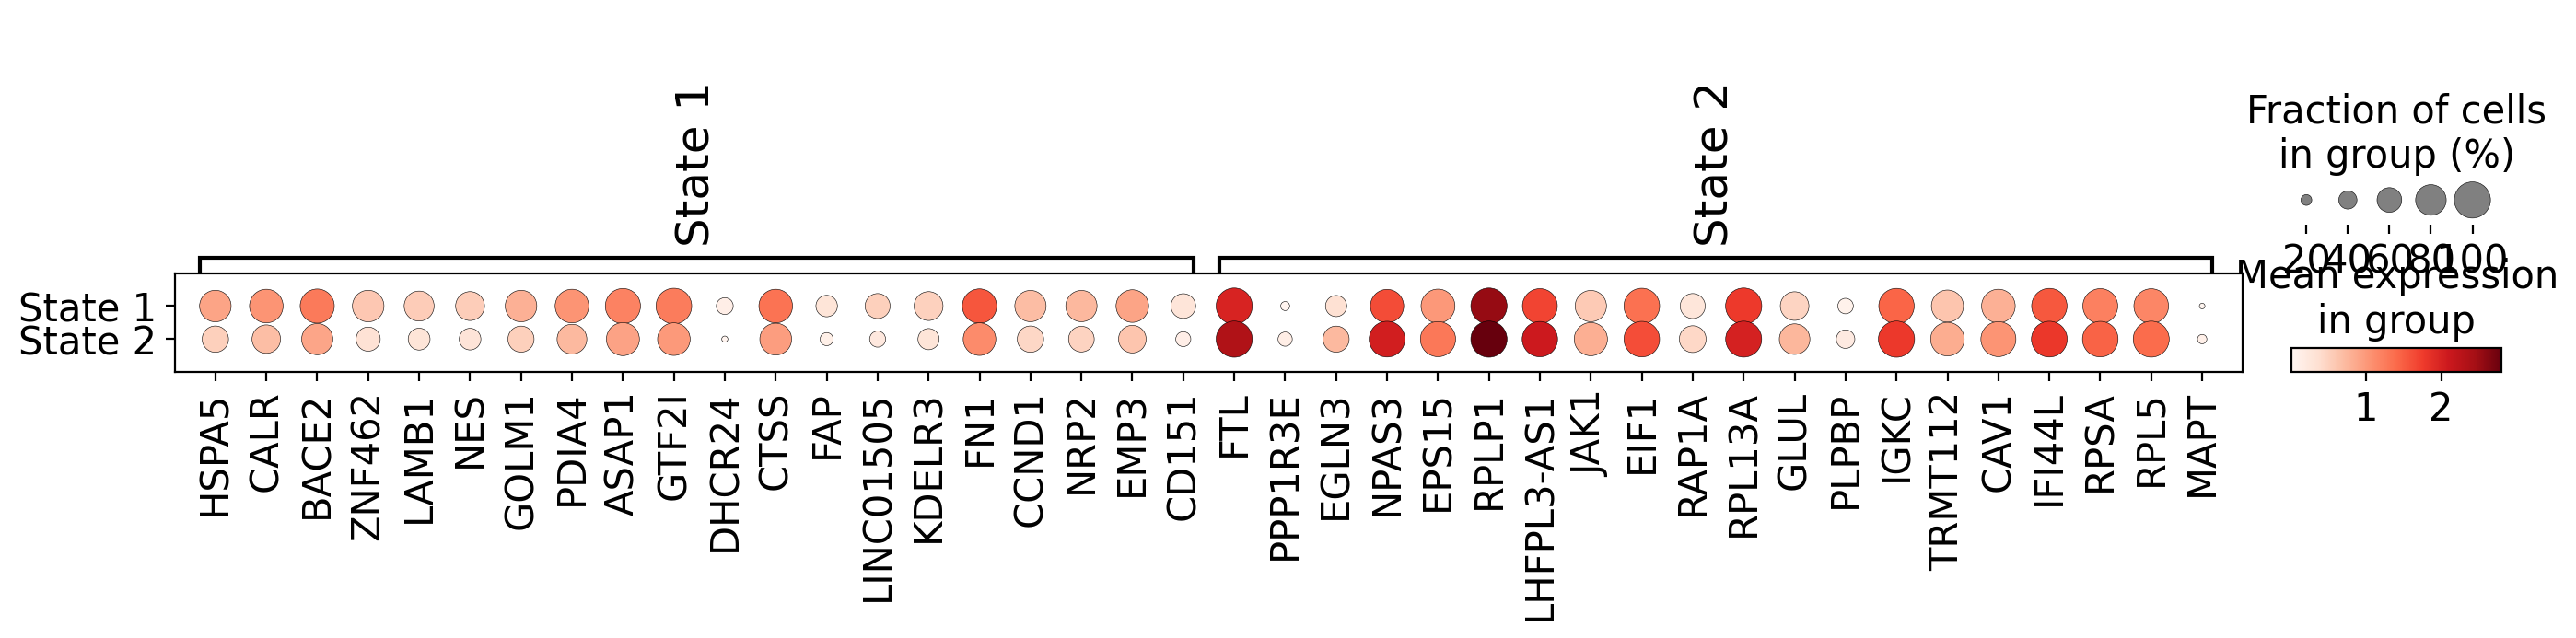

In [482]:
adata_rna_tumor2 = adata_rna[adata_rna.obs['cell_type']=='tumour_2'].copy()
adata_rna_tumor2.obs['leiden'] = adata_atac_se[adata_rna_tumor2.obs_names].obs['leiden'].values.copy()
adata_rna_tumor2 = adata_rna_tumor2[adata_rna_tumor2.obs['leiden'].isin(['4','1'])]
sc.tl.rank_genes_groups(adata_rna_tumor2,'state')
sc.pl.rank_genes_groups_dotplot(adata_rna_tumor2,n_genes=20)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


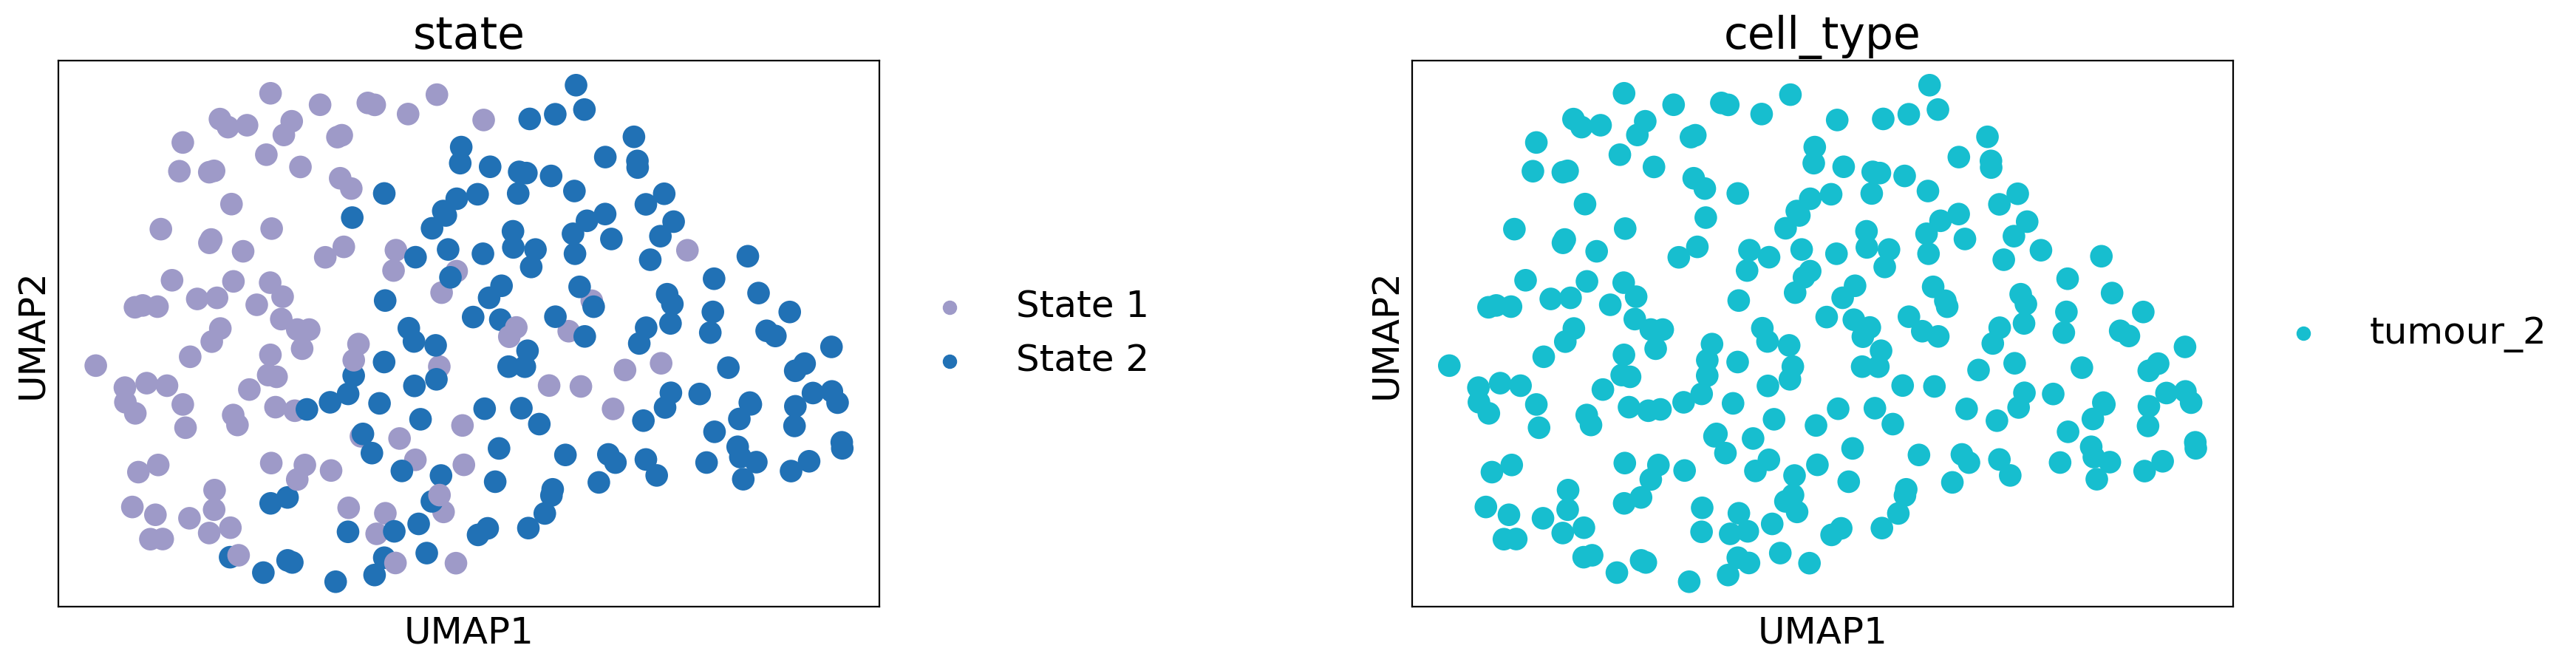

In [495]:
adata_rna_tumor2_se = adata_se[adata_rna_tumor2.obs_names].copy()
adata_rna_tumor2_se.obs['state'] = adata_rna_tumor2.obs['state'].values.copy()
sc.pp.pca(adata_rna_tumor2_se)
sc.pp.neighbors(adata_rna_tumor2_se)
sc.tl.umap(adata_rna_tumor2_se)

adata_rna_tumor2_se.uns['state_colors'] = adata_rna_tumor2.uns['state_colors'].copy()
sc.pl.umap(adata_rna_tumor2_se,color=['state','cell_type'],wspace=0.5)

In [435]:
name_df = pd.DataFrame(adata_rna_tumor2.uns['rank_genes_groups']['pvals']['1'],index=adata_rna_tumor2.uns['rank_genes_groups']['names']['1'])
name_df['logfoldchanges'] =adata_rna_tumor2.uns['rank_genes_groups']['logfoldchanges']['1']
name_df = name_df.loc[name_df[0]<0.05]
name_df = name_df.loc[name_df['logfoldchanges']>0.5]
name_df.to_csv('Bio_results/multiome/rna_tumor2_state1.csv')

name_df = pd.DataFrame(adata_rna_tumor2.uns['rank_genes_groups']['pvals']['4'],index=adata_rna_tumor2.uns['rank_genes_groups']['names']['4'])
name_df['logfoldchanges'] =adata_rna_tumor2.uns['rank_genes_groups']['logfoldchanges']['4']
name_df = name_df.loc[name_df[0]<0.05]
name_df = name_df.loc[name_df['logfoldchanges']>0.5]
name_df.to_csv('Bio_results/multiome/rna_tumor2_state2.csv')

In [432]:
name_df = pd.DataFrame(adata_atac_tumor2.uns['rank_genes_groups']['pvals']['1'],index=adata_atac_tumor2.uns['rank_genes_groups']['names']['1'])
name_df['logfoldchanges'] =adata_atac_tumor2.uns['rank_genes_groups']['logfoldchanges']['1']
name_df = name_df.loc[name_df[0]<0.05]
name_df = name_df.loc[name_df['logfoldchanges']>0.5]
name_df.to_csv('Bio_results/multiome/atac_tumor2_state1.csv')

name_df = pd.DataFrame(adata_atac_tumor2.uns['rank_genes_groups']['pvals']['4'],index=adata_atac_tumor2.uns['rank_genes_groups']['names']['4'])
name_df['logfoldchanges'] =adata_atac_tumor2.uns['rank_genes_groups']['logfoldchanges']['4']
name_df = name_df.loc[name_df[0]<0.05]
name_df = name_df.loc[name_df['logfoldchanges']>0.5]
name_df.to_csv('Bio_results/multiome/atac_tumor2_state2.csv')

In [427]:
name_df = pd.DataFrame(adata_atac_tumor2.uns['rank_genes_groups']['pvals_adj']['4'],index=adata_atac_tumor2.uns['rank_genes_groups']['names']['4'])
name_df['logfoldchanges'] =adata_atac_tumor2.uns['rank_genes_groups']['logfoldchanges']['4']
name_df

0  logfoldchanges
chr1-37807835-37808718    0.751944        2.306106
chr1-2555373-2556241      0.751944        1.689565
chr17-27950700-27951566   0.751944        3.293738
chr11-844523-845062       0.751944        2.445008
chr7-96321701-96322540    0.751944        2.061369
...                            ...             ...
chr3-48188097-48188972    0.751944       -2.924361
chr3-112042595-112043498  0.751944       -2.310922
chr2-219229230-219230077  0.751944       -1.968789
chr7-155282447-155283324  0.751944       -3.814485
chr17-47970529-47971423   0.751944       -2.476494

[53451 rows x 2 columns]

/tmp/ipykernel_3086809/1192501620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_atac_tumor2.obs['state'][adata_atac_tumor2.obs['leiden']=='4'] = 'State 2'


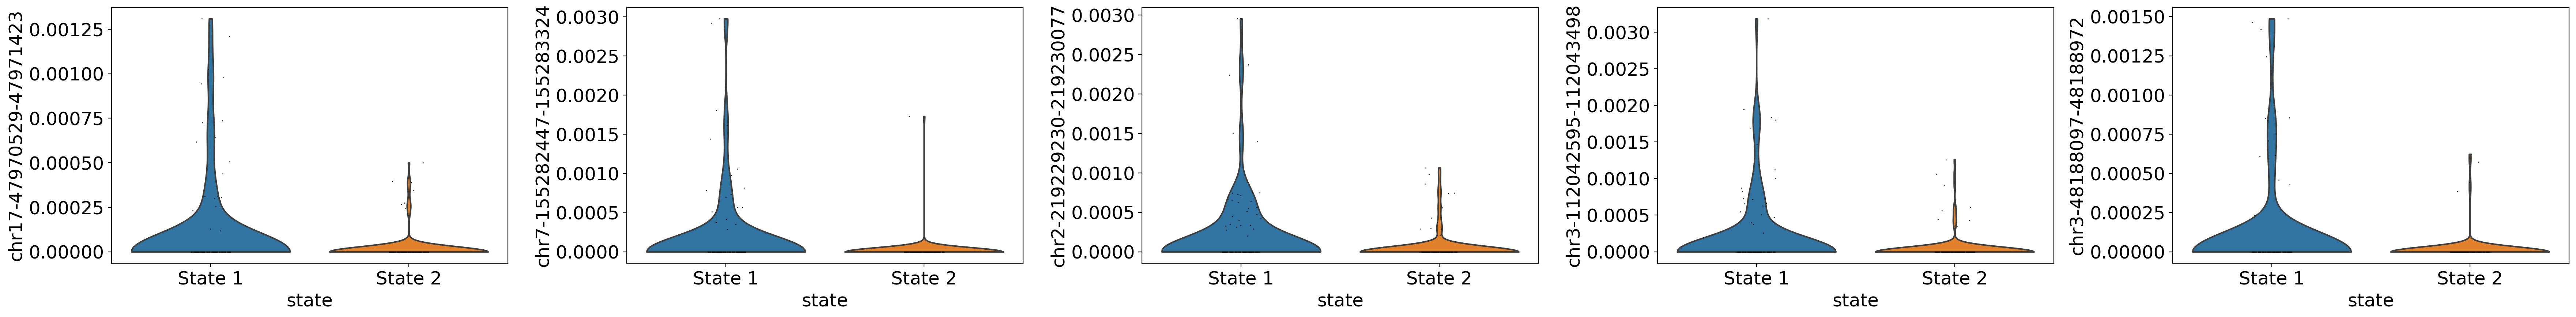

In [422]:
adata_atac_tumor2.obs['state'] = 'State 1'
adata_atac_tumor2.obs['state'][adata_atac_tumor2.obs['leiden']=='4'] = 'State 2'
sc.pl.violin(adata_atac_tumor2,adata_atac_tumor2.uns['rank_genes_groups']['names']['1'][0:5],'state',save='tumor2_state1.pdf')

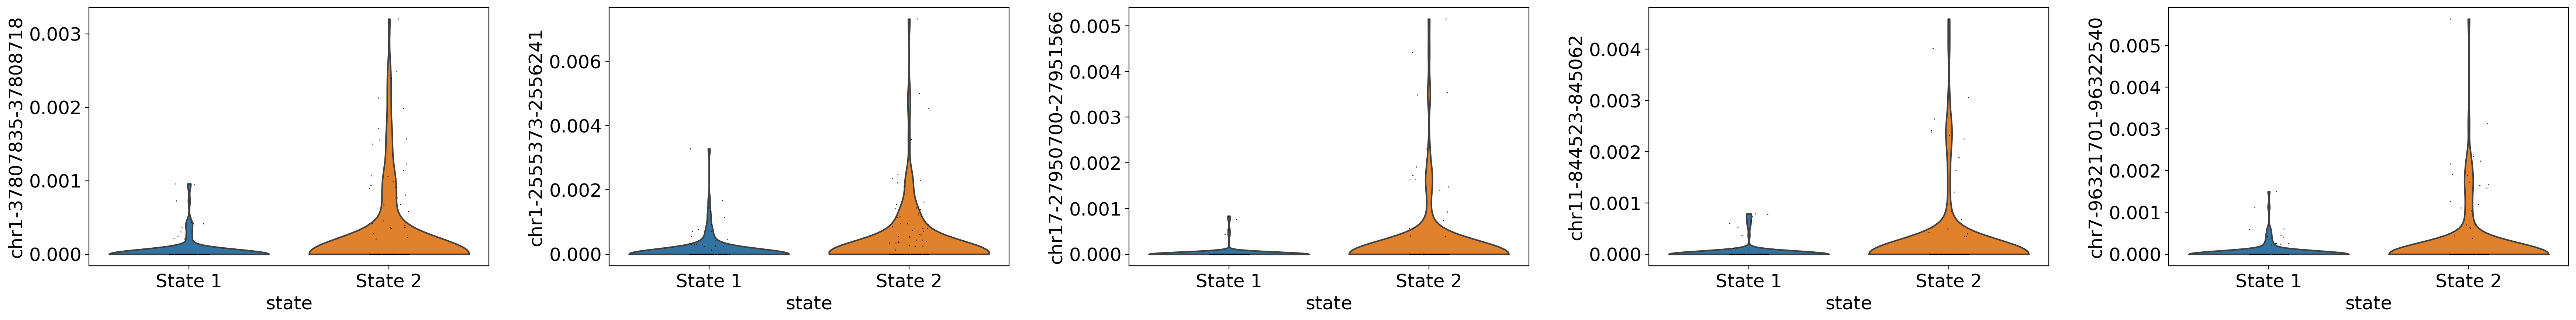

In [423]:
sc.pl.violin(adata_atac_tumor2,adata_atac_tumor2.uns['rank_genes_groups']['names']['4'][0:5],'state',save='tumor2_state2.pdf')

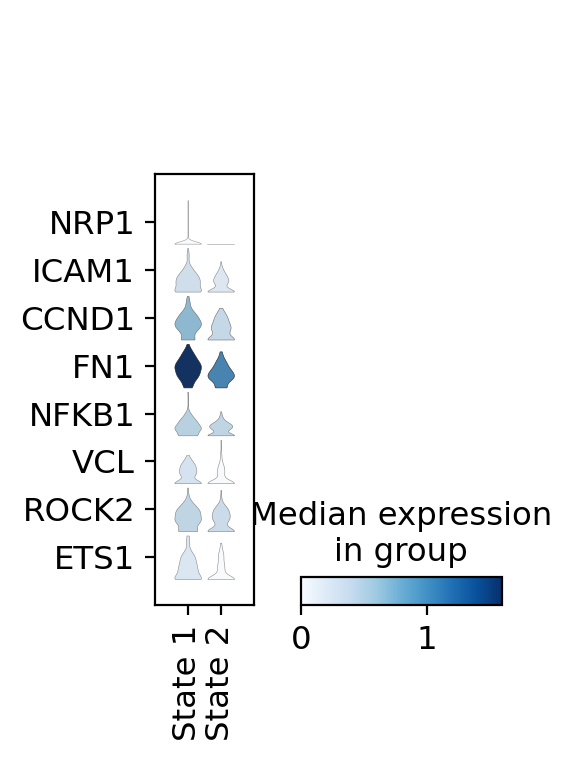

In [489]:
#adata_rna_tumor2.obs['state'] = adata_atac_tumor2.obs['state'].values.copy()
plt.rcParams["font.size"] = 14
sc.pl.stacked_violin(adata_rna_tumor2,['NRP1','ICAM1','CCND1','FN1','NFKB1','VCL','ROCK2','ETS1'],'state',swap_axes=True,save='rna_tumor2marker_swap.pdf')

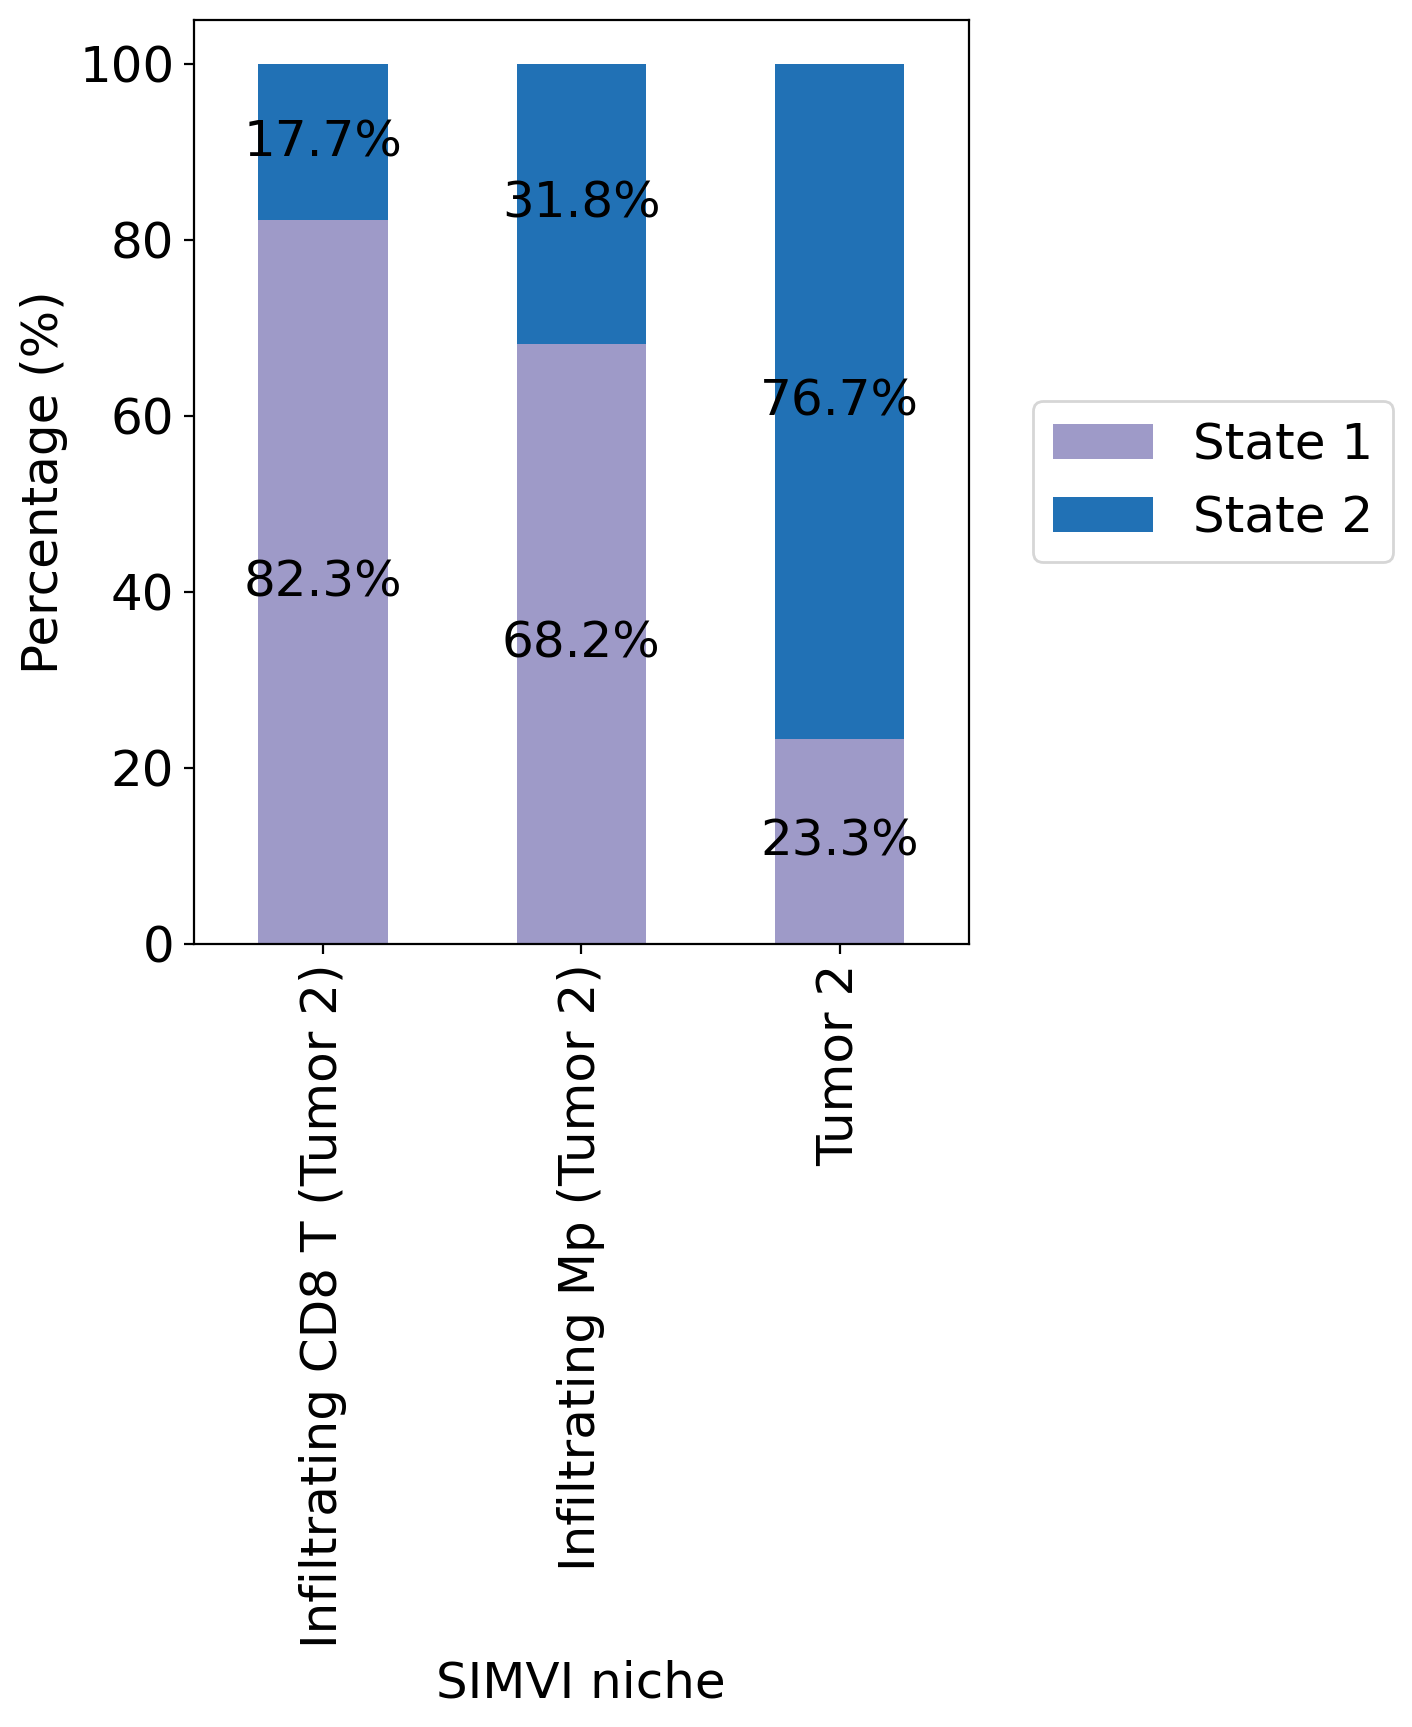

In [486]:
df = pd.DataFrame(adata_rna_tumor2.obs[['SIMVI niche','state']].copy())



# frequency
count_df = df.groupby(['SIMVI niche','state']).size().unstack(fill_value=0)

count_df = count_df.loc[count_df.values.sum(axis=1)>10]
count_df = count_df.div(count_df.sum(axis=1),axis=0) * 100


#count_df = count_df.reindex(["No stimulation", "IFN-III","IFNa2","IL-6","TNFa","IFNg","IFNb","IFNb+IL-6","IFNb + TNFa","IFNb+ IFNg"])
# draw plot
ax = count_df.plot(kind='bar', stacked=True,color=['#9e9ac8','#2171b5'],figsize=(5,6))


for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

#plt.xlabel('Category in col1')
plt.ylabel('Percentage (%)')
#plt.title('Stacked Bar Plot by col2 Categories in Each col1 Category')

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
#plt.xticks(rotation=0)
#plt.savefig('figures/tumor_environment_compo.pdf',bbox_inches='tight')

plt.show()

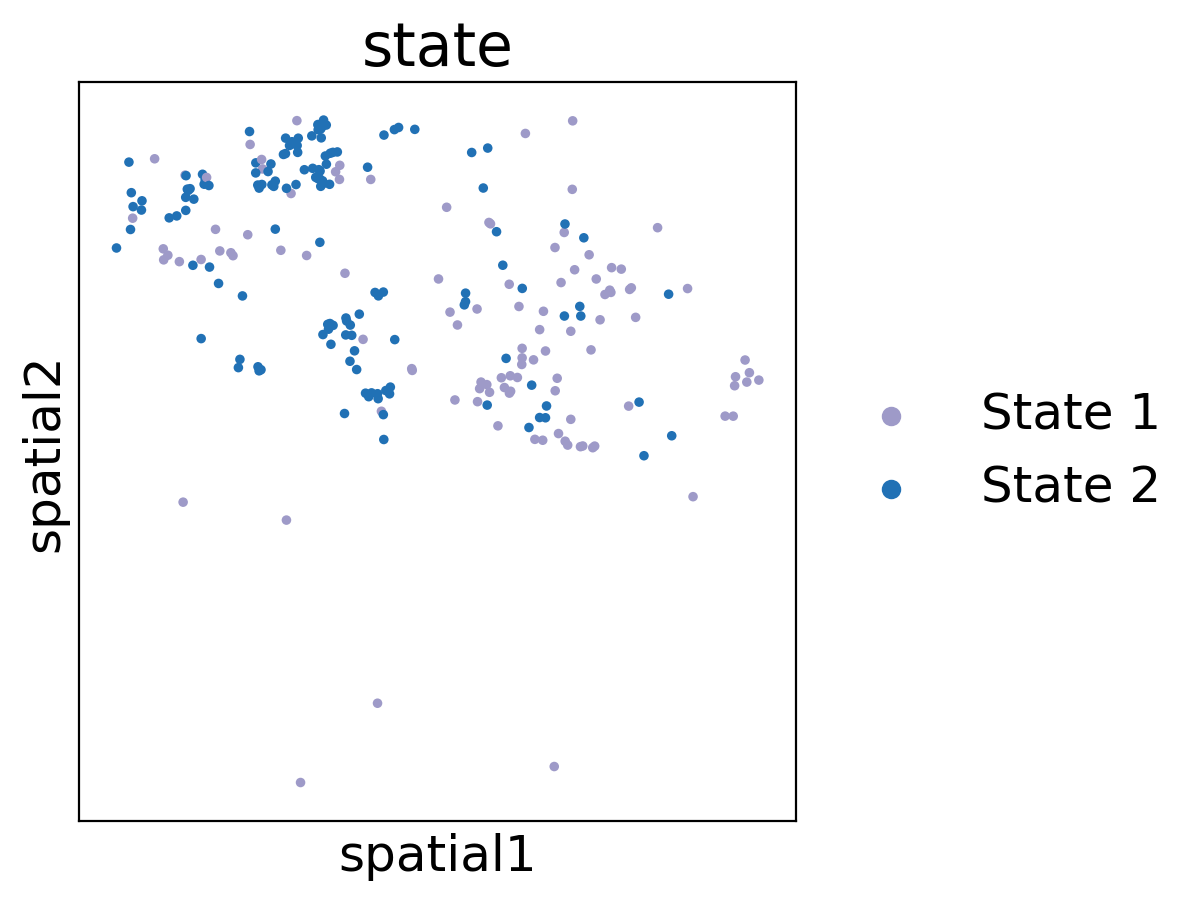

In [467]:
adata_rna_tumor2.uns['state_colors'] = ['#9e9ac8','#2171b5']
sc.pl.spatial(adata_rna_tumor2,color=['state'],spot_size=70,vmax=0.001,save='tumor2_state_.pdf')

In [461]:
adata_rna_tumor2.obs.to_csv('Bio_results/multiome/tumor2_obs.csv')

In [491]:
adata.obs.to_csv('Bio_results/multiome/adata_obs.csv')